# [실습] LangChain과 멀티모달 모델을 활용한 교통사고 판결 모델 만들기

In [1]:
import base64
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [2]:
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path("/Users/blueno/UNO/SKALA/SKALA/.env")
load_dotenv(dotenv_path=env_path, override=True)

# 환경 변수 확인
openai_api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", max_tokens=1024)

이미지를 첨부하기 위해서는, base64 방식의 인코딩이 필요합니다.

In [3]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

## 1. 사고 상황 분석하기

In [21]:
image = encode_image("images/car.jpg")

accident_analysis_prompt = ChatPromptTemplate.from_messages([
    ('system', """You are an expert in traffic accident analysis. Given a single image of a traffic accident scene, analyze the following:
    - Assess the scale of the accident (e.g., "minor", "moderate", "severe") based on the visible damage to the vehicle(s).
    - Provide a detailed description of the accident situation, including the likely cause, the position(s) of the vehicle(s), and any contributing factors inferred from the image. Assume two vehicles are involved unless only one is clearly present.
    - If only one vehicle is visible, infer the likely scenario involving another vehicle or object (e.g., a stationary object or road condition).

    Respond in Korean, and structure your output as a JSON object with the following format:
    {{
        "accident_scale": "<str>" ("minor", "moderate", "severe"),
        "description": {{
            "vehicle_positions": ["<str>", ...],
            "likely_cause": "<str>",
            "contributing_factors": ["<str>", ...]
        }},
        "involved_vehicles": <int> (1 or 2),
        "inferred_scenario": "<str>" (only if one vehicle is visible, otherwise "")
    }}
    Return the response strictly in JSON format, with no additional text outside the JSON structure."""),
    ('user', [
        {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image}"}}
    ])
])

list_chain = accident_analysis_prompt | llm | StrOutputParser()

accident_result = list_chain.invoke({'image':image})

print(accident_result)

```json
{
    "accident_scale": "severe",
    "description": {
        "vehicle_positions": ["BMW 차량이 왼쪽에 위치", "택시 차량이 오른쪽에 위치하고 오른쪽 앞 부분이 파손됨"],
        "likely_cause": "신호 위반이나 속도 초과",
        "contributing_factors": ["교차로에서의 충돌", "차선 변경 불이행"]
    },
    "involved_vehicles": 2,
    "inferred_scenario": ""
}
```


## 2. 예상 견적 도출

In [22]:
accident_cost_estimation_prompt = ChatPromptTemplate.from_messages([
    ('system', """You are an expert in traffic accident analysis, insurance estimation, and legal consequences in South Korea. Based on the accident analysis provided below, evaluate the following for each vehicle involved:
    - Repair Cost: Estimate the repair cost in KRW based on the extent of damage (e.g., minor: 500000-2000000, moderate: 2000000-5000000, severe: 5000000+).
    - Insurance Premium Increase: Predict the percentage increase in insurance premiums based on fault and damage (e.g., 10-50).
    - Fault Percentage: Assign a quantitative fault percentage (e.g., 30 for 30:70) based on the accident situation.
    - Criminal Liability: Assess the likelihood of criminal charges under Korean law (e.g., "low", "moderate", "high") and specify potential penalties (e.g., fine in KRW, license suspension duration in months).
    - Insurance Claim Process: Provide a step-by-step guide on how to file an insurance claim in South Korea, including required documents and expected processing time.
    - Legal Actions After the Accident: Explain possible legal actions that can be taken after the accident, including civil lawsuits, mediation options, and how to challenge an insurance company's decision.

    Provide two estimations labeled as "vehicle_a" and "vehicle_b" (if only one vehicle is present, estimate for that vehicle and infer the other party). Respond in Korean, and structure your output as a JSON object with the following format:
    {{
        "vehicle_a": {{
            "repair_cost": <int>,
            "premium_increase": <int>,
            "fault_percentage": <int>,
            "criminal_liability": {{
                "likelihood": "<str>" ("low", "moderate", "high"),
                "fine": <int>,
                "license_suspension_months": <int>
            }},
            "insurance_claim_process": ["<str>", ...],
            "legal_actions": ["<str>", ...]
        }},
        "vehicle_b": {{
            "repair_cost": <int>,
            "premium_increase": <int>,
            "fault_percentage": <int>,
            "criminal_liability": {{
                "likelihood": "<str>" ("low", "moderate", "high"),
                "fine": <int>,
                "license_suspension_months": <int>
            }},
            "insurance_claim_process": ["<str>", ...],
            "legal_actions": ["<str>", ...]
        }}
    }}
    Return the response strictly in JSON format, with no additional text outside the JSON structure."""),
    ('user', "Accident Analysis: {accident_analysis}")
])

accident_cost_estimation_chain = accident_cost_estimation_prompt | llm | StrOutputParser()

In [23]:
# LLM과 체인 설정
accident_analysis_chain = accident_analysis_prompt | llm | StrOutputParser()
accident_cost_estimation_chain = accident_cost_estimation_prompt | llm | StrOutputParser()

# 1. 사고 분석 실행
analysis_result = accident_analysis_chain.invoke({"image": image})

# 2. 견적 계산 단계
estimation_result = accident_cost_estimation_chain.invoke({"accident_analysis": analysis_result})

# 결과 출력
print(estimation_result)

```json
{
    "vehicle_a": {
        "repair_cost": 8000000,
        "premium_increase": 50,
        "fault_percentage": 70,
        "criminal_liability": {
            "likelihood": "high",
            "fine": 200000,
            "license_suspension_months": 6
        },
        "insurance_claim_process": [
            "사고 발생 후 즉시 보험사에 연락하기",
            "사고 접수 및 사고 상황 설명",
            "필요한 서류 준비: 사고 사진, 경찰 보고서, 개인 신분증",
            "보험 청구서 작성 및 제출",
            "보험사에서 접수 후 처리 기간은 대개 1~2개월 소요"
        ],
        "legal_actions": [
            "민사 소송 제기 가능",
            "보상에 대한 중재 신청",
            "보험사의 결정에 이의 제기"
        ]
    },
    "vehicle_b": {
        "repair_cost": 3500000,
        "premium_increase": 30,
        "fault_percentage": 30,
        "criminal_liability": {
            "likelihood": "moderate",
            "fine": 100000,
            "license_suspension_months": 3
        },
        "insurance_claim_process": [
            "사고 발생 후 즉시 보험사에 연락하기",
            "사고 접수 및 

## [실습] RunnableParallel.assign으로 중간 과정 보기

두 체인을 연결하여, 한 번의 실행으로 두 체인의 결과를 모두 확인할 수 있도록 만들어 보세요.

In [24]:
from langchain_core.runnables import RunnableParallel

# LLM 체인 설정
accident_analysis_chain = accident_analysis_prompt | llm | StrOutputParser()
accident_cost_estimation_chain = accident_cost_estimation_prompt | llm | StrOutputParser()

# 사고 분석 실행
analysis_result = accident_analysis_chain.invoke({"image": image})

# 병렬 실행을 통한 사고 비용 견적
chain = RunnableParallel(
    analysis_result=lambda _: analysis_result,
    estimation_result=lambda _: accident_cost_estimation_chain.invoke({"accident_analysis": analysis_result})
)

result = chain.invoke({})

# 결과 출력
print("\n🚗 **교통사고 분석 결과** 📄\n")
print(result["analysis_result"])
print("\n💰 **사고 견적 및 법적 대응** 📄\n")
print(result["estimation_result"])


🚗 **교통사고 분석 결과** 📄

```json
{
    "accident_scale": "severe",
    "description": {
        "vehicle_positions": ["다른 차의 앞쪽에 충돌한 택시", "충돌하고 있는 BMW"],
        "likely_cause": "신호 대기 중 서로의 주의 부족",
        "contributing_factors": ["교차로", "운전자의 방심", "차량 속도"]
    },
    "involved_vehicles": 2,
    "inferred_scenario": ""
}
```

💰 **사고 견적 및 법적 대응** 📄

```json
{
    "vehicle_a": {
        "repair_cost": 6000000,
        "premium_increase": 40,
        "fault_percentage": 50,
        "criminal_liability": {
            "likelihood": "moderate",
            "fine": 300000,
            "license_suspension_months": 3
        },
        "insurance_claim_process": [
            "보험사에 사고 신고",
            "사고 경위서 작성",
            "손해사정사와 상담",
            "수리 견적서 제출",
            "보험금 청구서 작성 및 제출",
            "보험사로부터의 지급 결정 대기"
        ],
        "legal_actions": [
            "민사소송 제기",
            "합의 중재 신청",
            "보험사 결정에 대한 이의 제기"
        ]
    },
    "vehicle_b": {
        "repair_cost": 

## 3. 그래프,차트 생성하기



🚗 **교통사고 분석 결과** 📄

{
  "accident_scale": "severe",
  "description": {
    "vehicle_positions": [
      "black BMW on the left",
      "black taxi on the right with a damaged front"
    ],
    "likely_cause": "collision at an intersection, possibly due to a failure to yield or running a red light",
    "contributing_factors": [
      "poor visibility",
      "traffic signal condition",
      "driver distraction"
    ]
  },
  "involved_vehicles": 2,
  "inferred_scenario": ""
}

💰 **사고 견적 및 법적 대응** 📄

{
  "vehicle_a": {
    "repair_cost": 6000000,
    "premium_increase": 40,
    "fault_percentage": 70,
    "criminal_liability": {
      "likelihood": "high",
      "fine": 500000,
      "license_suspension_months": 6
    },
    "insurance_claim_process": [
      "사고 현장 사진 찍기",
      "보험사에 사고 신고하기",
      "사고 경위서 작성하기",
      "사고 당시의 목격자 진술 확보하기",
      "진단서 및 수리 견적서 제출하기",
      "보험사에서의 사고 조사 기다리기",
      "보상금 지급 받기"
    ],
    "legal_actions": [
      "민사소송 제기하기",
      "보험사 결정에 이의신청하기",

/var/folders/fn/7bjmjvmn2d30b47j1yfz_5jm0000gn/T/ipykernel_6195/2981047550.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/fn/7bjmjvmn2d30b47j1yfz_5jm0000gn/T/ipykernel_6195/2981047550.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/fn/7bjmjvmn2d30b47j1yfz_5jm0000gn/T/ipykernel_6195/2981047550.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


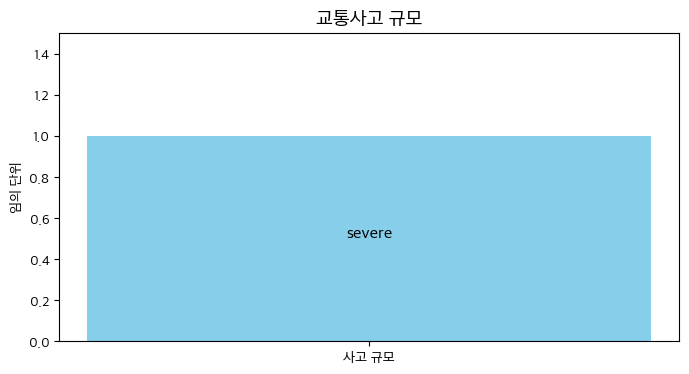

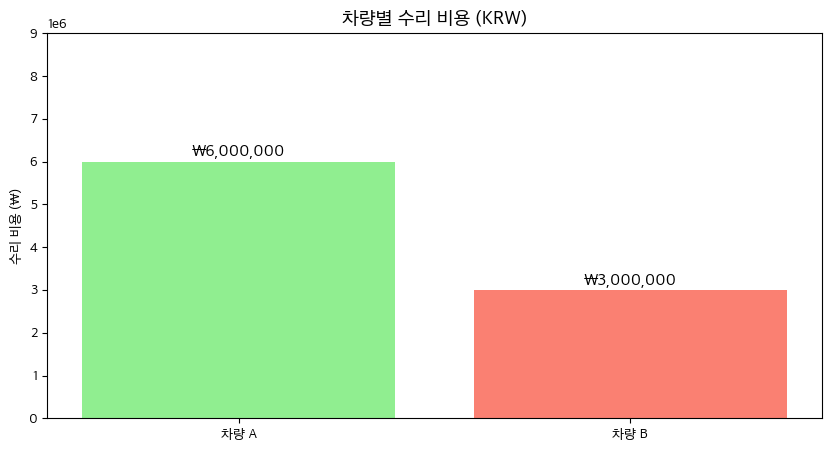

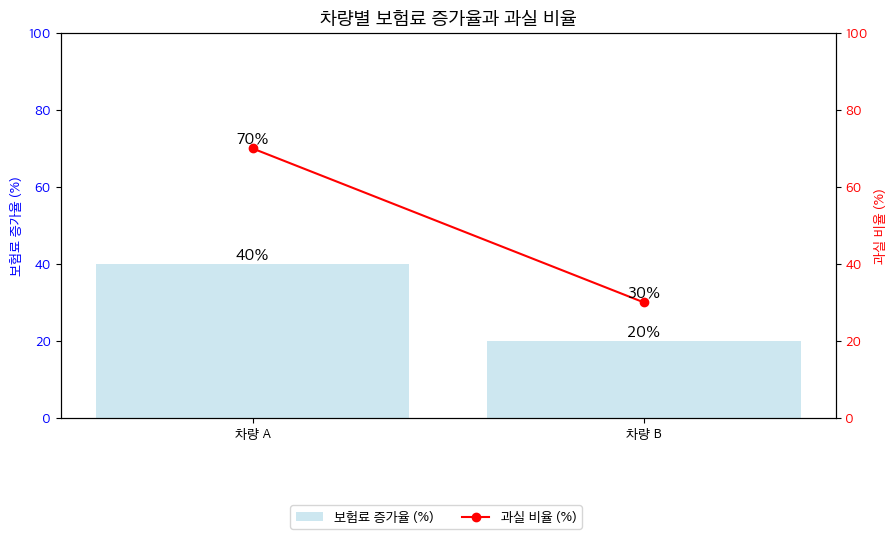

In [34]:
import json
from langchain_core.output_parsers import JsonOutputParser
import matplotlib.pyplot as plt
from langchain_core.runnables import RunnableParallel

# 데이터 파싱 함수
def parse_data(analysis_result, estimation_result):
    print("DEBUG - Analysis Result:", analysis_result)
    print("DEBUG - Estimation Result:", estimation_result)

    scale = analysis_result["accident_scale"]
    data = {
        "repair_cost": [
            estimation_result["vehicle_a"]["repair_cost"],
            estimation_result["vehicle_b"]["repair_cost"]
        ],
        "premium_increase": [
            estimation_result["vehicle_a"]["premium_increase"],
            estimation_result["vehicle_b"]["premium_increase"]
        ],
        "fault_percentage": [
            estimation_result["vehicle_a"]["fault_percentage"],
            estimation_result["vehicle_b"]["fault_percentage"]
        ]
    }
    return scale, data

# 그래프 그리기 함수
def plot_results(analysis_result, estimation_result):
    scale, data = parse_data(analysis_result, estimation_result)
    vehicles = ["차량 A", "차량 B"]

    # 1. 사고 규모 막대 그래프
    plt.figure(figsize=(8, 4))
    plt.bar(["사고 규모"], [1], color="skyblue")
    plt.title("교통사고 규모", fontsize=14)
    plt.text(0, 0.5, scale, ha="center", fontsize=12)
    plt.ylim(0, 1.5)
    plt.ylabel("임의 단위")
    plt.show()

    # 2. 차량별 수리 비용 막대 그래프
    plt.figure(figsize=(10, 5))
    plt.bar(vehicles, data["repair_cost"], color=["lightgreen", "salmon"])
    plt.title("차량별 수리 비용 (KRW)", fontsize=14)
    for i, v in enumerate(data["repair_cost"]):
        plt.text(i, v + 100000, f"₩{v:,}", ha="center", fontsize=12)
    plt.ylim(0, max(data["repair_cost"]) * 1.5 if max(data["repair_cost"]) > 0 else 1000000)
    plt.ylabel("수리 비용 (₩)")
    plt.show()

    # 3. 보험료 증가율과 과실 비율 비교
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.bar(vehicles, data["premium_increase"], color="lightblue", alpha=0.6, label="보험료 증가율 (%)")
    ax1.set_ylabel("보험료 증가율 (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(0, 100)
    for i, v in enumerate(data["premium_increase"]):
        ax1.text(i, v + 1, f"{v}%", ha="center", fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(vehicles, data["fault_percentage"], color="red", marker="o", label="과실 비율 (%)")
    ax2.set_ylabel("과실 비율 (%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0, 100)
    for i, v in enumerate(data["fault_percentage"]):
        ax2.text(i, v + 1, f"{v}%", ha="center", fontsize=12)

    plt.title("차량별 보험료 증가율과 과실 비율", fontsize=14)
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.show()

# LLM과 체인 설정
accident_analysis_chain = accident_analysis_prompt | llm | JsonOutputParser()
accident_cost_estimation_chain = accident_cost_estimation_prompt | llm | JsonOutputParser()

# 1. 사고 분석 실행
analysis_result = accident_analysis_chain.invoke({"image": image})

# 2. 병렬 실행 설정
chain = RunnableParallel(
    analysis_result=lambda _: analysis_result,
    estimation_result=lambda _: accident_cost_estimation_chain.invoke({"accident_analysis": json.dumps(analysis_result)})
)

# 3. 결과 받아오기
result = chain.invoke({})

# 4. 결과 출력
print("\n🚗 **교통사고 분석 결과** 📄\n")
print(json.dumps(result["analysis_result"], ensure_ascii=False, indent=2))
print("\n💰 **사고 견적 및 법적 대응** 📄\n")
print(json.dumps(result["estimation_result"], ensure_ascii=False, indent=2))

# 5. 그래프 그리기
plot_results(result["analysis_result"], result["estimation_result"])

## [최종] Gradio로 서비스 제작

In [35]:
import gradio as gr
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import json

# 한글 폰트 설정
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 레포트 생성 체인 추가
report_generation_prompt = ChatPromptTemplate.from_messages([
    ('system', """You are an expert in generating concise traffic accident reports in Korean. Based on the accident analysis and cost estimation provided below, create a single report summarizing the findings in a clear, structured format. Include the following sections:
    - 사고 개요: 사고 규모와 간단한 설명 (분석 결과 기반).
    - 차량별 분석:
      - 차량 A: 수리 비용, 보험료 증가율, 과실 비율, 형사 책임 (가능성, 벌금, 면허 정지 기간).
      - 차량 B: 수리 비용, 보험료 증가율, 과실 비율, 형사 책임 (가능성, 벌금, 면허 정지 기간).
    - 보험 청구 절차: 공통 절차 요약 (차량 A와 B의 절차가 동일하다고 가정).
    - 법적 조치: 가능한 조치 요약 (차량 A와 B의 조치를 통합).

    Ensure that both "vehicle_a" and "vehicle_b" from the cost estimation are fully reflected in the report. Respond in Korean, and structure your output as a plain text report with clear section headers. Do not include JSON or additional explanations beyond the report."""),
    ('user', "Accident Analysis: {analysis_result}\nCost Estimation: {estimation_result}")
])

report_generation_chain = report_generation_prompt | llm | StrOutputParser()

# 데이터 처리 및 Gradio 출력 함수
def process_accident(image):
    # 이미지 인코딩
    encoded_image = encode_image(image)

    # 사고 분석 실행
    analysis_result = accident_analysis_chain.invoke({"image": encoded_image})

    # 병렬 실행 설정
    chain = RunnableParallel(
        analysis_result=lambda _: analysis_result,
        estimation_result=lambda _: accident_cost_estimation_chain.invoke({"accident_analysis": json.dumps(analysis_result)})
    )
    result = chain.invoke({})

    # 레포트 생성
    report = report_generation_chain.invoke({
        "analysis_result": json.dumps(result["analysis_result"]),
        "estimation_result": json.dumps(result["estimation_result"])
    })

    # 그래프 생성
    scale = result["analysis_result"]["accident_scale"]
    data = {
        "repair_cost": [
            result["estimation_result"]["vehicle_a"]["repair_cost"],
            result["estimation_result"]["vehicle_b"]["repair_cost"]
        ],
        "premium_increase": [
            result["estimation_result"]["vehicle_a"]["premium_increase"],
            result["estimation_result"]["vehicle_b"]["premium_increase"]
        ],
        "fault_percentage": [
            result["estimation_result"]["vehicle_a"]["fault_percentage"],
            result["estimation_result"]["vehicle_b"]["fault_percentage"]
        ]
    }
    vehicles = ["차량 A", "차량 B"]

    # 그래프 1: 사고 규모
    plt.figure(figsize=(8, 4))
    plt.bar(["사고 규모"], [1], color="skyblue")
    plt.title("교통사고 규모", fontsize=14)
    plt.text(0, 0.5, scale, ha="center", fontsize=12)
    plt.ylim(0, 1.5)
    plt.ylabel("임의 단위")
    plt.savefig("accident_scale.png")
    plt.close()

    # 그래프 2: 수리 비용
    plt.figure(figsize=(10, 5))
    plt.bar(vehicles, data["repair_cost"], color=["lightgreen", "salmon"])
    plt.title("차량별 수리 비용 (KRW)", fontsize=14)
    for i, v in enumerate(data["repair_cost"]):
        plt.text(i, v + 100000, f"₩{v:,}", ha="center", fontsize=12)
    plt.ylim(0, max(data["repair_cost"]) * 1.5 if max(data["repair_cost"]) > 0 else 1000000)
    plt.ylabel("수리 비용 (₩)")
    plt.savefig("repair_cost.png")
    plt.close()

    # 그래프 3: 보험료 증가율과 과실 비율
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.bar(vehicles, data["premium_increase"], color="lightblue", alpha=0.6, label="보험료 증가율 (%)")
    ax1.set_ylabel("보험료 증가율 (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(0, 100)
    for i, v in enumerate(data["premium_increase"]):
        ax1.text(i, v + 1, f"{v}%", ha="center", fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(vehicles, data["fault_percentage"], color="red", marker="o", label="과실 비율 (%)")
    ax2.set_ylabel("과실 비율 (%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0, 100)
    for i, v in enumerate(data["fault_percentage"]):
        ax2.text(i, v + 1, f"{v}%", ha="center", fontsize=12)

    plt.title("차량별 보험료 증가율과 과실 비율", fontsize=14)
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.savefig("premium_fault.png")
    plt.close()

    return report, "accident_scale.png", "repair_cost.png", "premium_fault.png"

# Gradio 인터페이스
with gr.Blocks(title="교통사고 분석기") as demo:
    gr.Markdown("# 교통사고 분석기")
    gr.Markdown("사고 이미지를 업로드하면 최종 레포트와 그래프를 확인할 수 있습니다.")
    
    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="사고 이미지 업로드")
            submit_btn = gr.Button("분석 시작")
        with gr.Column():
            report_output = gr.Textbox(label="최종 사고 레포트", lines=15)
    
    with gr.Row():
        scale_plot = gr.Image(label="사고 규모")
        repair_plot = gr.Image(label="수리 비용")
        premium_fault_plot = gr.Image(label="보험료 증가율과 과실 비율")

    submit_btn.click(
        fn=process_accident,
        inputs=image_input,
        outputs=[report_output, scale_plot, repair_plot, premium_fault_plot]
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
